In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter
from sklearn.model_selection import train_test_split


In [2]:
df = pd.read_csv('/Users/itscodezero/Documents/UOL/M6-NLP/MMA/data/train.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
# Add a new column 'non-toxic' to the DataFrame with values 0 or 1, where 0 represent the comment falls under any one of the category
df['non-toxic'] = (df['toxic'] == 0) & (df['severe_toxic'] == 0) & (df['obscene'] == 0) & (df['threat'] == 0) & (df['insult'] == 0) & (df['identity_hate'] == 0)
df['non-toxic'] = df['non-toxic'].astype(int)  # Convert boolean to integer (True -> 1, False -> 0)

In [5]:
toxicity_counts = df.iloc[:, 2:].apply(pd.Series.value_counts)
print(toxicity_counts)

# Get the positive count of each category
category_totals = toxicity_counts.iloc[1].sort_values(ascending=False)
print(category_totals)

    toxic  severe_toxic  obscene  threat  insult  identity_hate  non-toxic
0  144277        157976   151122  159093  151694         158166      16225
1   15294          1595     8449     478    7877           1405     143346
non-toxic        143346
toxic             15294
obscene            8449
insult             7877
severe_toxic       1595
identity_hate      1405
threat              478
Name: 1, dtype: int64


<Axes: >

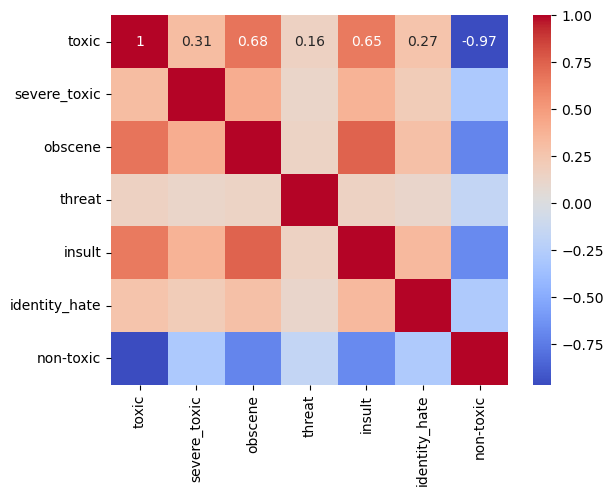

In [6]:
# Calculate the correlation matrix 
corr_matrix = df.iloc[:, 2:].corr()

# Plot the correlation heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

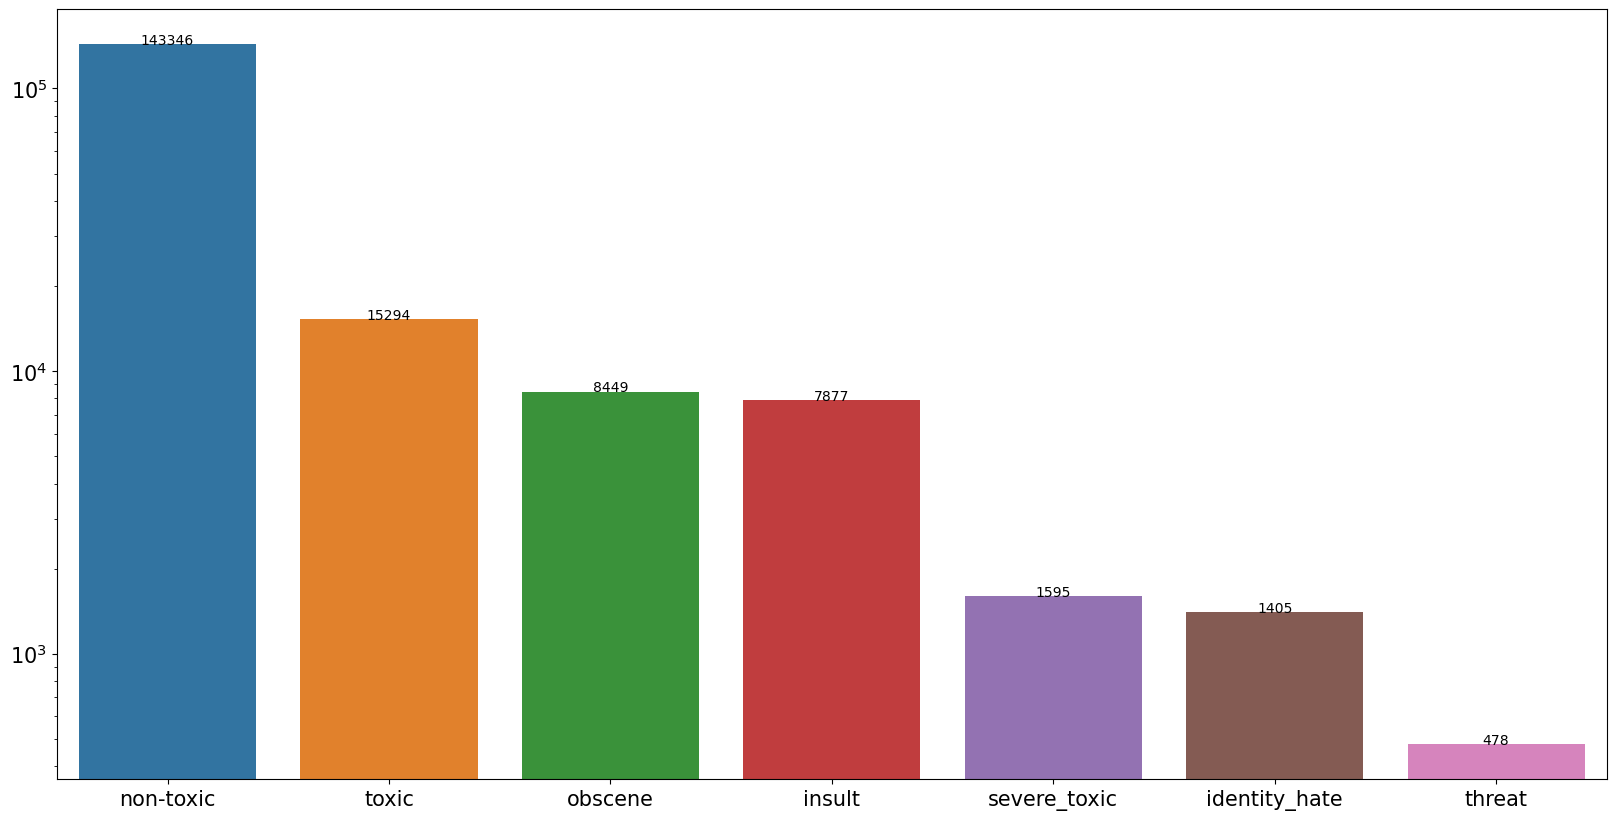

In [7]:
plt.figure(figsize=(20, 10))
bp = sns.barplot(x=category_totals.index, y=category_totals.values)
for i in range(len(category_totals)):
    bp.text(i, category_totals.iloc[i], category_totals.iloc[i], ha = 'center')

bp.set_yscale("log")
bp.tick_params(labelsize=15)

## Dataset balancing

/var/folders/kf/mvzkysrj6zbb9fg2ksrxn7zc0000gn/T/ipykernel_3935/3104332450.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bp.text(i, category_totals[i], category_totals[i], ha = 'center')


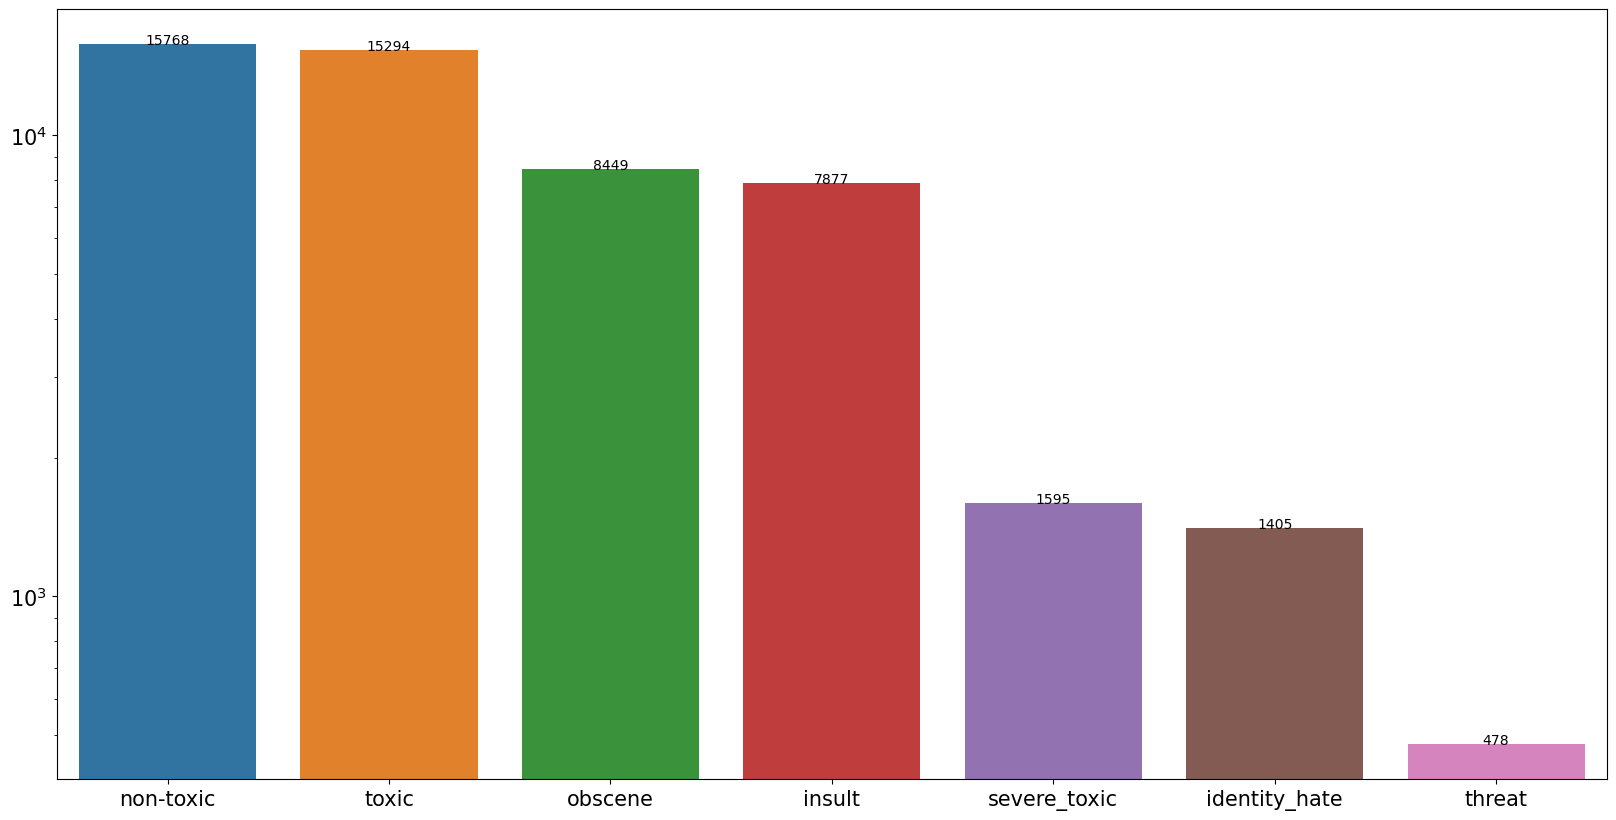

In [9]:
df_balanced = pd.concat([df[df['non-toxic'] == 1].sample(frac=0.11), df.loc[df['non-toxic'] == 0]])

# Shuffle the DataFrame
df_balanced = df_balanced.sample(frac=1)

toxicity_counts = df_balanced.iloc[:, 2:].apply(pd.Series.value_counts)
category_totals = toxicity_counts.iloc[1].sort_values(ascending=False)

plt.figure(figsize=(20, 10))
bp = sns.barplot(x=category_totals.index, y=category_totals.values)
#show the count on the barplot
for i in range(len(category_totals)):
    bp.text(i, category_totals[i], category_totals[i], ha = 'center')
bp.set_yscale("log")
bp.tick_params(labelsize=15)

In [10]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
# Load English tokenizer, tagger, parser, NER, and word vectors
nlp = spacy.load("en_core_web_sm")

processed_tokens = []
processed_comments = []

for doc in nlp.pipe(df_balanced['comment_text'].astype('unicode').values, batch_size=100):
    tokens=[token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token.is_digit and token.is_alpha]
    # make lowercase and remove whitespaces
    t_list=[token.lower() for token in tokens]
    processed_tokens.append(t_list)
    processed_comments.append(' '.join(t_list))



print('Unprocessed text:', df_balanced['comment_text'].head())
# Apply preprocessing to the 'comment_text' column
df_balanced['processed_comment_text'] = processed_comments
df_balanced['processed_tokens'] = processed_tokens
print('Processed text:', df_balanced['processed_comment_text'].head())

print('processed_tokens:',df_balanced['processed_tokens'].head())

/opt/anaconda3/envs/tensorflow/lib/python3.12/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.1.0) was trained with spaCy v3.1.0 and may not be 100% compatible with the current version (3.7.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Unprocessed text: 61828                     how bout \n\nyou go fuck yourself
4910      Apparently I wasn't clear enough the first tim...
156511    , 20 June 2011 (UTC)\n\nOh shut up Bong, your ...
153550       WP:AIV \n\nYou'll be blocked now. (talk|email)
16908     "\n\n Please do not vandalize pages, as you di...
Name: comment_text, dtype: object
Processed text: 61828                                             bout fuck
4910      apparently clear time sine pompous flame diety...
156511        june utc oh shut bong deleting fun god damnit
153550                                         wp aiv block
16908     vandalize page edit trench warfare continue bl...
Name: processed_comment_text, dtype: object
processed_tokens: 61828                                          [bout, fuck]
4910      [apparently, clear, time, sine, pompous, flame...
156511    [june, utc, oh, shut, bong, deleting, fun, god...
153550                                     [wp, aiv, block]
16908     [vandalize, page, ed

('fuck', 'suck', 'shit', 'like', 'nigger', 'wikipedia', 'fucking', 'hate', 'ass', 'u', 'page', 'know', 'gay', 'die', 'edit', 'faggot', 'fat', 'moron', 'people', 'block')
(9104, 4398, 3644, 3635, 3416, 3399, 2943, 2738, 2679, 2580, 2557, 2485, 2260, 2168, 2126, 2001, 1970, 1932, 1925, 1880)


/opt/anaconda3/envs/tensorflow/lib/python3.12/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


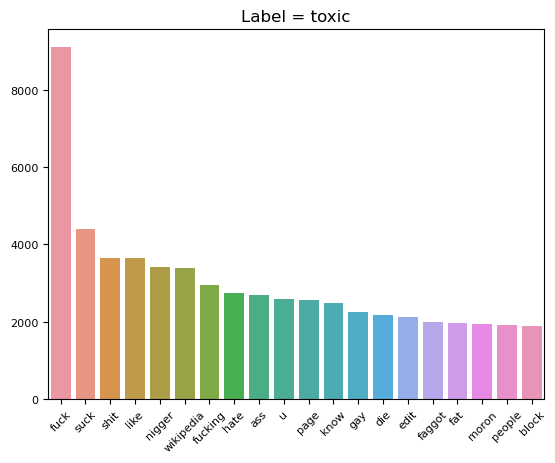

<Figure size 2000x2000 with 0 Axes>

('fuck', 'suck', 'shit', 'ass', 'faggot', 'u', 'fucking', 'die', 'cunt', 'nigger', 'cock', 'bitch', 'wikipedia', 'fucksex', 'yourselfgo', 'fucker', 'kill', 'dick', 'cocksucker', 'piece')
(6159, 3142, 1887, 1842, 1574, 1365, 1311, 1164, 1037, 1015, 914, 779, 687, 624, 621, 593, 585, 527, 509, 507)


/opt/anaconda3/envs/tensorflow/lib/python3.12/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


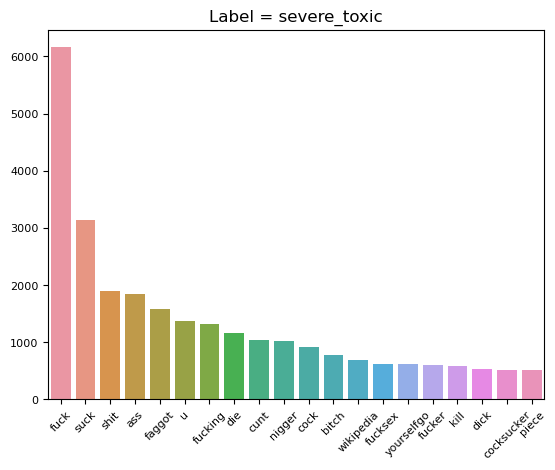

<Figure size 2000x2000 with 0 Axes>

('fuck', 'suck', 'shit', 'fucking', 'nigger', 'ass', 'u', 'cunt', 'wikipedia', 'like', 'bitch', 'dick', 'know', 'fat', 'page', 'cock', 'die', 'faggot', 'edit', 'bullshit')
(8996, 3909, 3227, 2861, 2827, 2585, 2046, 1772, 1696, 1620, 1468, 1314, 1292, 1282, 1277, 1253, 1210, 1204, 1188, 1085)


/opt/anaconda3/envs/tensorflow/lib/python3.12/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


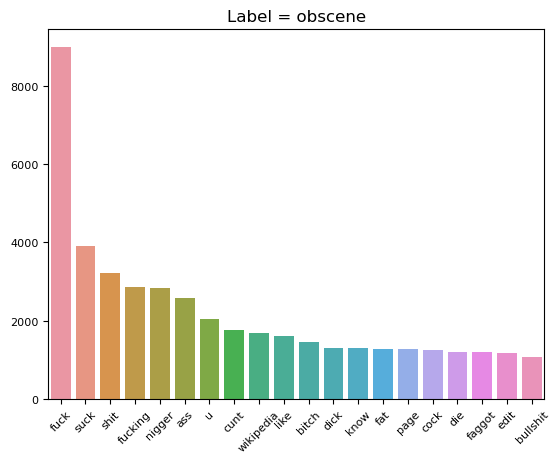

<Figure size 2000x2000 with 0 Axes>

('die', 'ass', 'kill', 'go', 'block', 'jim', 'wales', 'fuck', 'page', 'ban', 'fucking', 'talk', 'wikipedia', 'murder', 'live', 'fuckin', 'rvv', 'blank', 'di', 'edie')
(1176, 772, 520, 298, 187, 158, 156, 154, 137, 136, 125, 121, 120, 109, 106, 101, 96, 94, 91, 90)


/opt/anaconda3/envs/tensorflow/lib/python3.12/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


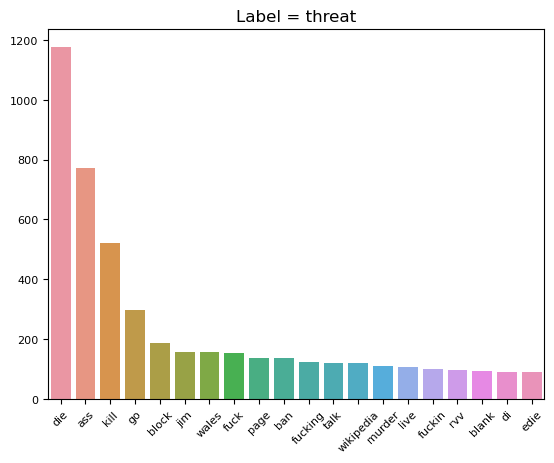

<Figure size 2000x2000 with 0 Axes>

('fuck', 'suck', 'nigger', 'fucking', 'u', 'ass', 'fat', 'faggot', 'shit', 'cunt', 'like', 'moron', 'hate', 'hi', 'bitch', 'jew', 'wikipedia', 'know', 'die', 'page')
(6966, 3632, 2884, 2515, 1953, 1944, 1927, 1840, 1702, 1678, 1629, 1507, 1428, 1399, 1397, 1307, 1293, 1272, 1254, 1099)


/opt/anaconda3/envs/tensorflow/lib/python3.12/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


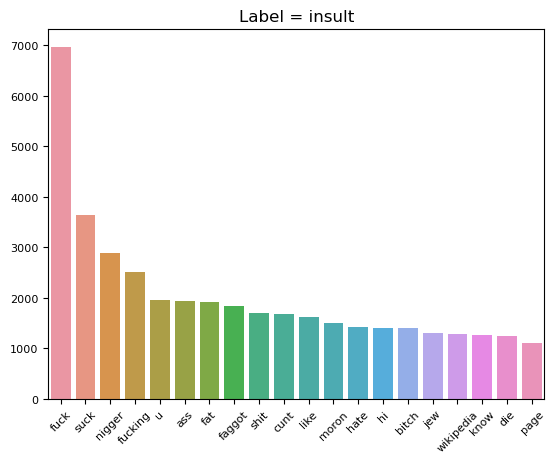

<Figure size 2000x2000 with 0 Axes>

('nigger', 'fat', 'jew', 'fuck', 'gay', 'die', 'faggot', 'suck', 'nigga', 'fucking', 'huge', 'shit', 'like', 'cunt', 'stupid', 'ass', 'mexican', 'bitch', 'hate', 'bunksteve')
(3081, 1322, 1314, 975, 930, 885, 698, 522, 507, 458, 430, 412, 407, 403, 394, 373, 361, 357, 316, 278)


/opt/anaconda3/envs/tensorflow/lib/python3.12/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


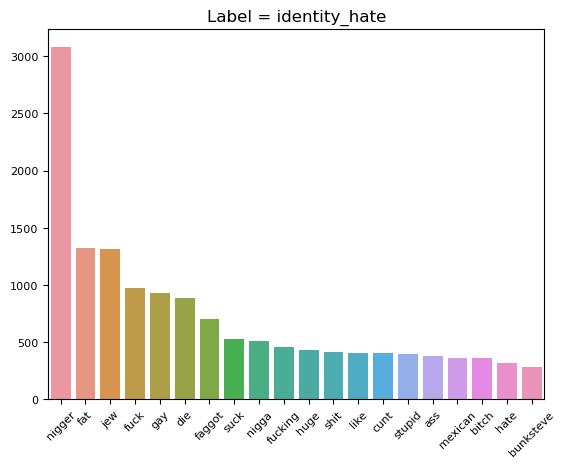

<Figure size 2000x2000 with 0 Axes>

In [11]:
target_columns = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

for label in target_columns:
    filtered_df = df_balanced[df_balanced[label] == 1]
    word_list = list(filtered_df['processed_tokens'].explode())
    most_common = Counter(word_list).most_common(20)
    top_words, word_counts = zip(*most_common)
    print(top_words)
    print(word_counts)
    # Create and customize the plot
    ax = sns.barplot(x=list(top_words), y=list(word_counts))

    ax.set_title(f'Label = {label}', fontsize=12)
    ax.tick_params(labelsize=8)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.figure(figsize=(20, 20))
    plt.show() 


## TF-IDF vectorization.

In [16]:
vectorizer = TfidfVectorizer(ngram_range=(1, 5), max_features=100000)
vectorizer.fit(df_balanced['processed_comment_text'])
vectorizer

TfidfVectorizer(max_features=100000, ngram_range=(1, 5))

In [61]:
# divide the dataset into train and validation set
X_train, X_val, y_train, y_val = train_test_split(df_balanced['processed_comment_text'], df_balanced[target_columns], test_size=0.2, random_state=42)


In [62]:
X_val.head()

58260                 oh shake boot big bad admin nut bitch
49487     wow lawyer kind half assed lawyer believe inno...
149977    agree worthless scum fuck luckily intelligent ...
23191                                 nah acccurate grosser
50088     far argument able like notable page get news w...
Name: processed_comment_text, dtype: object

In [63]:
X_train = vectorizer.transform(X_train)
X_val = vectorizer.transform(X_val)

## Support Vector Classification

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Create an SVM classifier for each label
# add AUC score and ROC curve

svm_classifiers = {}
for label in target_columns:
    # Create an SVM classifier
    classifier = SVC(kernel='linear')
    
    # Fit the classifier on the training data
    classifier.fit(X_train, y_train[label])
    
    # Make predictions on the validation data
    y_pred = classifier.predict(X_val)
    
    # Evaluate the classifier
    report = classification_report(y_val[label], y_pred)
    print(f"Label: {label}")
    print(report)
    print(f'AUC: {roc_auc_score(y_val[label], y_pred)}')
   
    # Store the classifier
    svm_classifiers[label] = classifier


## Logistic Regression

In [ ]:
# Create logistic regression classifier for each label
from sklearn.linear_model import LogisticRegression

logistic_classifiers = {}
for label in target_columns:
    # Create a logistic regression classifier
    classifier = LogisticRegression(max_iter=1000)
    
    # Fit the classifier on the training data
    classifier.fit(X_train, y_train[label])
    
    # Make predictions on the validation data
    y_pred = classifier.predict(X_val)
    
    # Evaluate the classifier
    report = classification_report(y_val[label], y_pred)
    print(f"Label: {label}")
    print(f'AUC: {roc_auc_score(y_val[label], y_pred)}')
    print(report)
   
    
    # Store the classifier
    logistic_classifiers[label] = classifier


In [67]:
# Create adaboost classifier for each label
from sklearn.ensemble import AdaBoostClassifier

adaboost_classifiers = {}
for label in target_columns:
    # Create an AdaBoost classifier
    classifier = AdaBoostClassifier()
    
    # Fit the classifier on the training data
    classifier.fit(X_train, y_train[label])
    
    # Make predictions on the validation data
    y_pred = classifier.predict(X_val)
    
    # Evaluate the classifier
    report = classification_report(y_val[label], y_pred)
    print(f"Label: {label}")
    print(f'AUC: {roc_auc_score(y_val[label], y_pred)}')
    print(report)
    
    # Store the classifier
    adaboost_classifiers[label] = classifier

/opt/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Label: toxic
AUC: 0.8090331608995253
              precision    recall  f1-score   support

           0       0.76      0.94      0.84      3320
           1       0.91      0.68      0.78      3079

    accuracy                           0.81      6399
   macro avg       0.83      0.81      0.81      6399
weighted avg       0.83      0.81      0.81      6399



/opt/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Label: severe_toxic
AUC: 0.5993436925927282
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      6085
           1       0.49      0.21      0.29       314

    accuracy                           0.95      6399
   macro avg       0.72      0.60      0.63      6399
weighted avg       0.94      0.95      0.94      6399



/opt/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Label: obscene
AUC: 0.8453887884267631
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      4740
           1       0.87      0.73      0.79      1659

    accuracy                           0.90      6399
   macro avg       0.89      0.85      0.86      6399
weighted avg       0.90      0.90      0.90      6399



/opt/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Label: threat
AUC: 0.5903122766587419
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6290
           1       0.53      0.18      0.27       109

    accuracy                           0.98      6399
   macro avg       0.76      0.59      0.63      6399
weighted avg       0.98      0.98      0.98      6399



/opt/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Label: insult
AUC: 0.7484466918788013
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      4802
           1       0.77      0.55      0.64      1597

    accuracy                           0.85      6399
   macro avg       0.82      0.75      0.77      6399
weighted avg       0.84      0.85      0.84      6399



/opt/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Label: identity_hate
AUC: 0.6462135520471376
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      6117
           1       0.61      0.30      0.40       282

    accuracy                           0.96      6399
   macro avg       0.79      0.65      0.69      6399
weighted avg       0.95      0.96      0.95      6399



In [68]:
# Create Multinomial Naive Bayes classifier for each label
from sklearn.naive_bayes import MultinomialNB

nb_classifiers = {}
for label in target_columns:
    # Create a Multinomial Naive Bayes classifier
    classifier = MultinomialNB()
    
    # Fit the classifier on the training data
    classifier.fit(X_train, y_train[label])
    
    # Make predictions on the validation data
    y_pred = classifier.predict(X_val)
    
    # Evaluate the classifier
    report = classification_report(y_val[label], y_pred)
    print(f"Label: {label}")
    print(f'AUC: {roc_auc_score(y_val[label], y_pred)}')
    print(report)
    
    # Store the classifier
    nb_classifiers[label] = classifier

Label: toxic
AUC: 0.8535309637380311
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      3320
           1       0.88      0.81      0.84      3079

    accuracy                           0.86      6399
   macro avg       0.86      0.85      0.85      6399
weighted avg       0.86      0.86      0.85      6399

Label: severe_toxic
AUC: 0.5098317885161906
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      6085
           1       0.30      0.02      0.04       314

    accuracy                           0.95      6399
   macro avg       0.63      0.51      0.51      6399
weighted avg       0.92      0.95      0.93      6399

Label: obscene
AUC: 0.7021097046413503
              precision    recall  f1-score   support

           0       0.83      0.98      0.90      4740
           1       0.89      0.42      0.57      1659

    accuracy                           0.84      6399
   macro

In [70]:
# create Multi-LayerPerceptron classifier for each label
from sklearn.neural_network import MLPClassifier

mlp_classifiers = {}
for label in target_columns:
    # Create a Multi-Layer Perceptron classifier
    classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000)
    
    # Fit the classifier on the training data
    classifier.fit(X_train, y_train[label])
    
    # Make predictions on the validation data
    y_pred = classifier.predict(X_val)
    
    # Evaluate the classifier
    report = classification_report(y_val[label], y_pred)
    print(f"Label: {label}")
    print(f'AUC: {roc_auc_score(y_val[label], y_pred)}')
    print(report)
    
    # Store the classifier
    mlp_classifiers[label] = classifier

Label: toxic
AUC: 0.8355647663730595
              precision    recall  f1-score   support

           0       0.83      0.86      0.84      3320
           1       0.84      0.81      0.83      3079

    accuracy                           0.84      6399
   macro avg       0.84      0.84      0.84      6399
weighted avg       0.84      0.84      0.84      6399



/opt/anaconda3/envs/tensorflow/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Label: severe_toxic
AUC: 0.622109813732212
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      6085
           1       0.44      0.26      0.33       314

    accuracy                           0.95      6399
   macro avg       0.70      0.62      0.65      6399
weighted avg       0.94      0.95      0.94      6399

